# Loss Landscape Experiments

In [1]:
import copy
import torch
import torch.optim as optim
from data import *
from model import *

data_dim = 4
batch_size = 48

torch.backends.cudnn.benchmark = True
_encoder, _decoder = Encoder(data_dim), Decoder(data_dim)
train, val = load_train_val(1, batch_size, "hollywood2")

def make_encoder_decoder():
    """
    Create a copy of the encoder and decoder with the same initialization.
    """
    encoder, decoder = copy.deepcopy(_encoder), copy.deepcopy(_decoder)
    return encoder.cuda(), decoder.cuda()

def flatten_weights(models):
    """
    Extracts a flat numpy array of weights from a list of PyTorch models.
    """
    parameters = []
    for model in models:
        for x in model.parameters():
            parameters.append(x.detach().view(-1).cpu())
    parameters = torch.cat(parameters, dim=0)
    return parameters.numpy()

def load_weights(models, weights):
    """
    Loads a flat numpy array of weights into the PyTorch models.
    """
    offset = 0
    for model in models:
        for x in model.parameters():
            x.data.copy_(torch.from_numpy(weights[offset:offset+x.view(-1).size(0)]).view(x.size()))
            offset += x.view(-1).size(0)

data/hollywood2/val: 100%|██████████| 884/884 [00:04<00:00, 210.85it/s]


In [2]:
import itertools
import numpy as np
import torch.nn.functional as F

def make_XY(frames, paired=True):
    frames = frames.cuda()
    data = torch.zeros(frames.size(0), data_dim).random_(0, 2).cuda()
    if paired:
        frames = torch.cat([frames, frames], dim=0).cuda()
        data = torch.cat([data, 1.0 - data], dim=0).cuda()
    return frames, data

class ModelLogger(object):
    
    def __init__(self, lr=1e-4, paired=False):
        self.losses = []
        self.weights = []
        self.paired = paired
        self.encoder, self.decoder = make_encoder_decoder()
        self.optimizer = optim.Adam(itertools.chain(
            self.encoder.parameters(), 
            self.decoder.parameters()
        ), lr=lr)
    
    def step(self, nb_steps=1):
        for step in range(nb_steps):
            test_loss = []
            with torch.no_grad():
                for frames in tqdm(val):
                    frames, data = make_XY(frames, paired=self.paired)
                    wm_frames = self.encoder(frames, data)
                    wm_data = self.decoder(wm_frames)
                    loss = F.binary_cross_entropy_with_logits(wm_data, data)
                    test_loss.append(loss.item())
            self.weights.append(flatten_weights([self.encoder, self.decoder]))
            self.losses.append(np.mean(test_loss))

            for frames in tqdm(train):
                frames, data = make_XY(frames, paired=self.paired)
                self.optimizer.zero_grad()
                wm_frames = self.encoder(frames, data)
                wm_data = self.decoder(wm_frames)
                loss = F.binary_cross_entropy_with_logits(wm_data, data)
                loss.backward()
                self.optimizer.step()
        return self

In [3]:
loggers = {}
loggers["paired"] = ModelLogger(paired=True).step(nb_steps=10)
loggers["unpaired"] = ModelLogger(paired=False).step(nb_steps=10)

100%|██████████| 35/35 [02:18<00:00,  3.84s/it]


In [4]:
import numpy as np
from itertools import chain
from sklearn.decomposition import IncrementalPCA

def extract_principal_components(loggers):
    """
    Compute the principal components along which the gradients vary.
    """
    grads = []
    for model in loggers.values():
        grads.extend([model.weights[t] - model.weights[-1] for t in range(1, len(model.weights))])
    return IncrementalPCA(2, whiten=True).fit(grads)

def make_contour_grid(pca, loggers, resolution=10):
    """
    Examine the loss values along the grid in the PCA subspace.
    """
    weights = []
    for model in loggers.values():
        weights.extend(model.weights)
    xy = pca.transform(weights)
    x, y = xy[:,0], xy[:,1]
    xi = np.linspace(np.min(x), np.max(x), resolution)
    yi = np.linspace(np.min(y), np.max(y), resolution)
    
    X, Y, Z = [], [], []
    encoder, decoder = make_encoder_decoder()
    for x in xi:
        for y in tqdm(yi):
            weights = pca.inverse_transform([[x,y]])[0]
            load_weights([encoder, decoder], weights)
            
            test_loss = []
            with torch.no_grad():
                for frames in val:
                    frames, data = make_XY(frames, paired=True)
                    wm_frames = encoder(frames, data)
                    wm_data = decoder(wm_frames)
                    loss = F.binary_cross_entropy_with_logits(wm_data, data)
                    test_loss.append(loss.item())
                    break
            X.append(x)
            Y.append(y)
            Z.append(np.mean(test_loss))
    return X, Y, Z

pca = extract_principal_components(loggers)
X, Y, Z = make_contour_grid(pca, loggers)

100%|██████████| 10/10 [01:33<00:00,  9.37s/it]


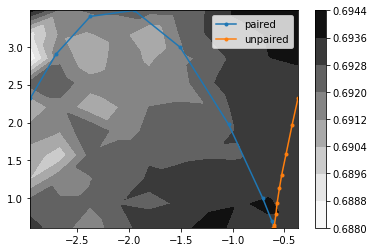

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Create grid values first.
ngridx, ngridy = 100, 100
xi = np.linspace(np.min(X), np.max(X), ngridx)
yi = np.linspace(np.min(Y), np.max(Y), ngridy)

# Perform linear interpolation of the data (x,y)
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='linear', fill_value=np.max(Z))
cs = plt.contourf(xi, yi, zi, cmap="Greys")
cbar = plt.colorbar(cs)

for name, model in loggers.items():
    XY = pca.transform(model.weights)
    plt.plot(XY[:,0], XY[:,1], label=name, marker=".")
plt.legend();

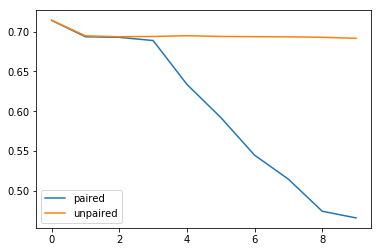

In [6]:
for name, model in loggers.items():
    plt.plot(model.losses, label=name)
plt.legend();